In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt


/home/nwertheim/miniconda3/bin/python


In [14]:
data_file = os.path.join(univariate_data_path, 'merged_univariate.npy')
data = np.load(data_file, allow_pickle=True)
print(data.shape)

# Check for NaN or Inf values in signals
for sample in data:
    if np.isnan(sample['signal']).any() or np.isinf(sample['signal']).any():
        print(f"NaN or Inf detected in {sample['record_name']}")


print(data[0]['signal'].shape)
print(data[0])



(666,)
(7600, 1)
{'record_name': 'ice001_l_1of1', 'signal': array([[-1.7358303 ],
       [-0.30347557],
       [-0.40749874],
       ...,
       [-3.09738299],
       [-2.90981482],
       [-3.22768386]]), 'metadata': {'fs': 20, 'sig_len': 100000, 'n_sig': 16, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'comments': ['Info:', 'ID:ice001', 'Record type:labour', 'Record number:1/1', 'Age(years):31', 'BMI before pregnancy:23.3', 'BMI at recording:27.6', 'Gravidity:3', 'Parity:2', 'Previous caesarean:No', 'Placental position:Fundus', 'Gestational age at recording(w/d):39/3', 'Gestational age at delivery:39/3', 'Mode of delivery:Vaginal', 'Synthetic oxytocin use in labour:No', 'Epidural during labour:No', 'Comments for recording:', 'Electrodes placed 5-10 mins prior to beginning of recording.', 'Baby born 20 minutes after the end of the recording.']}}


In [15]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


windows = create_time_windows(data)
print(windows.shape)
print(windows[0].shape)

(1550, 12000)
(12000,)


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(windows, test_size=0.1, val_size=0.1, random_seed=42):
    """
    Splits the dataset into training, validation, and test sets with specified proportions.
    
    Parameters:
    - windows (numpy.ndarray): The dataset to split, shaped as (num_samples, window_size).
    - test_size (float): Proportion of data to be used for the test set.
    - val_size (float): Proportion of data to be used for the validation set.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - X_train, X_val, X_test: The splits of the dataset.
    """
    # First, split into train and temp (test + validation)
    X_train, X_temp = train_test_split(windows, test_size=(test_size + val_size), random_state=random_seed)
    
    # Then, split the temp into validation and test
    val_size_adjusted = val_size / (val_size + test_size)  # Adjust to split remaining temp
    X_val, X_test = train_test_split(X_temp, test_size=val_size_adjusted, random_state=random_seed)
    
    return X_train, X_val, X_test

# Example usage with your windows data
X_train, X_val, X_test = split_data(windows, test_size=0.1, val_size=0.1)

# Check the shapes of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (1240, 12000)
Validation set shape: (155, 12000)
Test set shape: (155, 12000)


In [17]:
def mask_data(x, mask_ratio=0.5, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.2  # Adjust this to your desired masking ratio
masked_X_train = mask_data(X_train, mask_ratio)
masked_X_val = mask_data(X_val, mask_ratio)
masked_X_test = mask_data(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Validation set shape: {masked_X_val.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (1240, 12000)
Masked Validation set shape: (155, 12000)
Masked Test set shape: (155, 12000)


In [18]:
# import matplotlib.pyplot as plt

# def plot_masked_examples(original, masked, num_examples=5):
#     plt.figure(figsize=(15, num_examples * 2.5))
    
#     for i in range(num_examples):
#         # Original signal
#         plt.subplot(num_examples, 2, 2*i + 1)
#         plt.plot(original[i], color='blue')
#         plt.title(f"Original Signal {i+1}")
#         plt.xlabel("Time step")
#         plt.ylabel("Amplitude")

#         # Masked signal
#         plt.subplot(num_examples, 2, 2*i + 2)
#         plt.plot(masked[i], color='orange')
#         plt.title(f"Masked Signal {i+1}")
#         plt.xlabel("Time step")
#         plt.ylabel("Amplitude")

#     plt.tight_layout()
#     plt.show()
# plot_masked_examples(windows, masked_windows, num_examples=5)


In [19]:
class ConvNeXtBlock1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # Modify groups dynamically to match the input channels
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)  # Depthwise conv
        self.norm = nn.LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # Pointwise conv1 (expand)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)  # Pointwise conv2 (project)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)  # (B, C, L)
        x = x.permute(0, 2, 1)  # (B, L, C) for LayerNorm
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x + shortcut.permute(0, 2, 1)
        return x.permute(0, 2, 1)  # (B, C, L)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class FCMAE(nn.Module):
    def __init__(self, in_channels=1, base_dim=64, num_blocks=3, kernel_size=7):
        super(FCMAE, self).__init__()

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder blocks: reduce sequence length
        current_channels = in_channels
        for i in range(num_blocks):
            out_channels = base_dim * (2 ** i)
            self.encoder.append(nn.Conv1d(current_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2))
            self.encoder.append(nn.BatchNorm1d(out_channels))
            self.encoder.append(nn.ReLU())
            current_channels = out_channels

        # Decoder blocks: upsample back to original length
        for i in reversed(range(num_blocks)):
            out_channels = base_dim * (2 ** i)
            self.decoder.append(nn.ConvTranspose1d(current_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2, output_padding=1))
            self.decoder.append(nn.BatchNorm1d(out_channels))
            self.decoder.append(nn.ReLU())
            current_channels = out_channels

        # Final layer to return to original number of input channels
        self.output_layer = nn.Conv1d(current_channels, in_channels, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.output_layer(x)
        return x

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Convert to tensors (still on CPU at this point)
masked_X_train_tensor = torch.tensor(masked_X_train, dtype=torch.float32).unsqueeze(1)
masked_X_val_tensor = torch.tensor(masked_X_val, dtype=torch.float32).unsqueeze(1)
masked_X_test_tensor = torch.tensor(masked_X_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(masked_X_train_tensor)
val_dataset = TensorDataset(masked_X_val_tensor)
test_dataset = TensorDataset(masked_X_test_tensor)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define model
model = FCMAE(in_channels=1, num_blocks=3)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FCMAE(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(256, 256, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(256, 128, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()

Epoch [1/20] - Train Loss: 0.4455, Val Loss: 0.2985
Epoch [2/20] - Train Loss: 0.0863, Val Loss: 0.0400
Epoch [3/20] - Train Loss: 0.0315, Val Loss: 0.0225
Epoch [4/20] - Train Loss: 0.0208, Val Loss: 0.0159
Epoch [5/20] - Train Loss: 0.0157, Val Loss: 0.0124
Epoch [6/20] - Train Loss: 0.0125, Val Loss: 0.0103
Epoch [7/20] - Train Loss: 0.0112, Val Loss: 0.0089
Epoch [8/20] - Train Loss: 0.0101, Val Loss: 0.0079
Epoch [9/20] - Train Loss: 0.0089, Val Loss: 0.0070
Epoch [10/20] - Train Loss: 0.0081, Val Loss: 0.0064
Epoch [11/20] - Train Loss: 0.0076, Val Loss: 0.0059
Epoch [12/20] - Train Loss: 0.0073, Val Loss: 0.0055
Epoch [13/20] - Train Loss: 0.0071, Val Loss: 0.0050
Epoch [14/20] - Train Loss: 0.0064, Val Loss: 0.0048
Epoch [15/20] - Train Loss: 0.0062, Val Loss: 0.0043
Epoch [16/20] - Train Loss: 0.0058, Val Loss: 0.0040
Epoch [17/20] - Train Loss: 0.0046, Val Loss: 0.0038
Epoch [18/20] - Train Loss: 0.0051, Val Loss: 0.0036
Epoch [19/20] - Train Loss: 0.0049, Val Loss: 0.0034
Ep

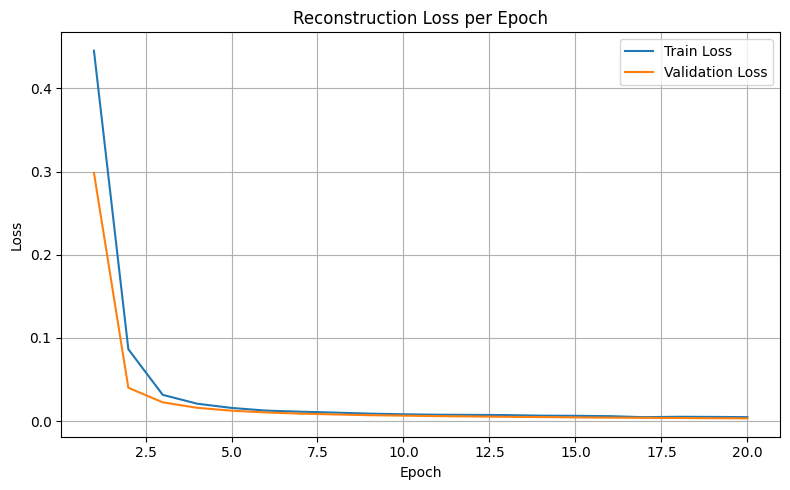

In [22]:
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_epoch_loss = 0.0

    for batch in train_loader:
        batch_input = batch[0].to(device)

        optimizer.zero_grad()
        output = model(batch_input)
        loss = criterion(output, batch_input)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    avg_train_loss = train_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch_input = batch[0].to(device)
            output = model(batch_input)
            loss = criterion(output, batch_input)
            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotting after training
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reconstruction Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


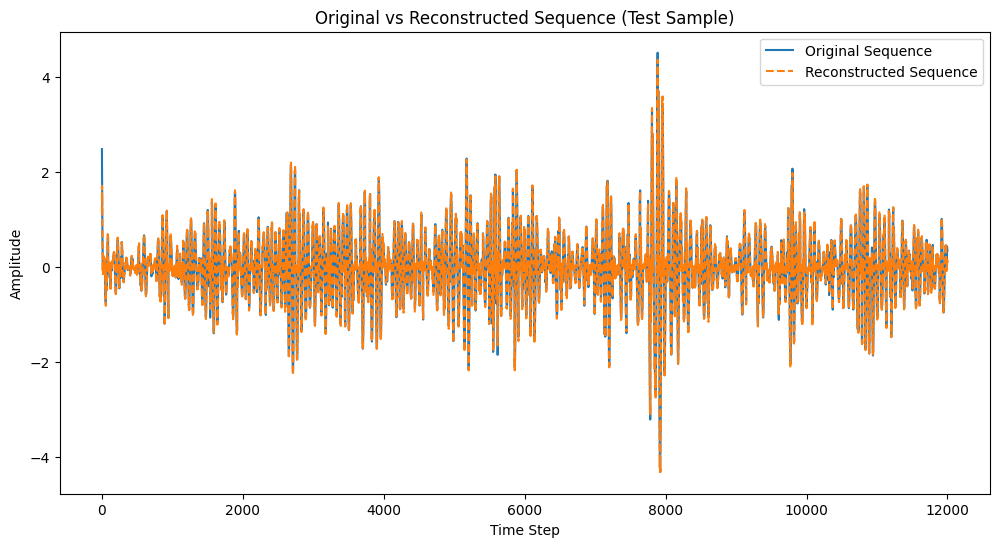

In [23]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode (no gradient tracking)
model.eval()

# Choose a test sample (here, we take the first sample from the test_loader)
with torch.no_grad():  # Disable gradient calculation for inference
    # Get a batch from the test loader
    for batch in test_loader:
        batch_input = batch[0].to(device)  # Move batch to the device (GPU or CPU)
        
        # Get the reconstruction from the model
        output = model(batch_input)

        # Take the first test sample (index 0)
        original_sequence = batch_input[0].cpu().numpy().flatten()  # Flatten for easier plotting
        reconstructed_sequence = output[0].cpu().numpy().flatten()

        # Plotting the original and reconstructed sequence
        plt.figure(figsize=(12, 6))
        plt.plot(original_sequence, label="Original Sequence")
        plt.plot(reconstructed_sequence, label="Reconstructed Sequence", linestyle='--')
        plt.legend()
        plt.title("Original vs Reconstructed Sequence (Test Sample)")
        plt.xlabel("Time Step")
        plt.ylabel("Amplitude")
        plt.show()

        break  # Only plot for the first test batch (you can modify this if you want to loop through more samples)


In [24]:
# Define the path where you want to save the encoder
path = os.path.join(models_path, 'FCMAE_encoder.pth')

# Save the encoder part of the model
torch.save(model.state_dict(), path)

print(f"Model encoder saved to {path}")

Model encoder saved to ../models/FCMAE_encoder.pth
